In [1]:
from phoenix import distributionfunction, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyp

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "N0_spheroid": 1e6,
    "J0_spheroid": 1000.0,
    "Gamma_spheroid": 2.5,
    "Beta_spheroid": 3.5,
}

In [3]:
envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

In [4]:
Phi_spheroid = plummer_potential

theta_spheroid = jnp.array([1e12, 10000.0]) # (M, a) z.B. für Plummer

In [5]:
#Generate candidate actions
from phoenix.distributionfunctions_spheroidal import f_double_power_law as df_spheroid
candidates, samples, soft_weights = sampling.sample_df_potential_single(df_spheroid, key, params, Phi_spheroid, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

Number of candidate actions: 500000


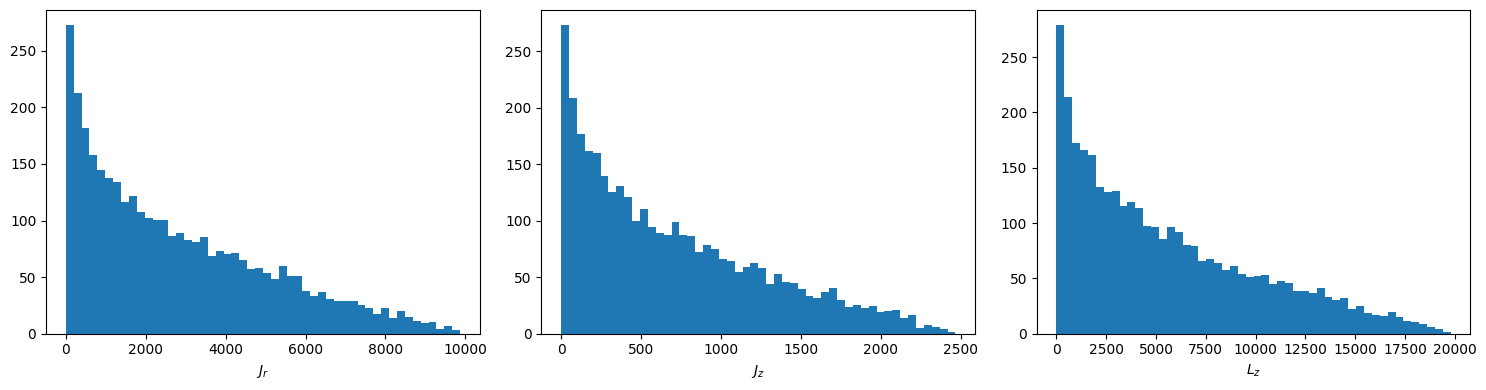

In [6]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

In [7]:
#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi_spheroid, theta_spheroid)

Phase-space coordinates shape: (500000, 6)


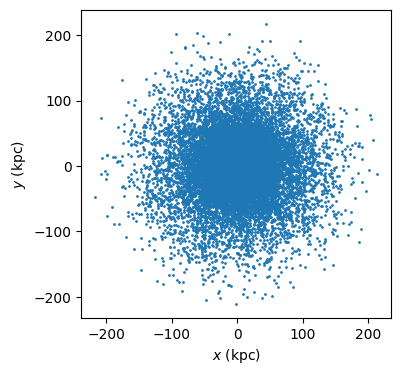

In [8]:
print("Phase-space coordinates shape:", phase_space_coords.shape)

#Plot a x-y scatter plot to visualize the distribution
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

plt.figure(figsize=(4, 4))
plt.scatter(x, y, s=1)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.show()

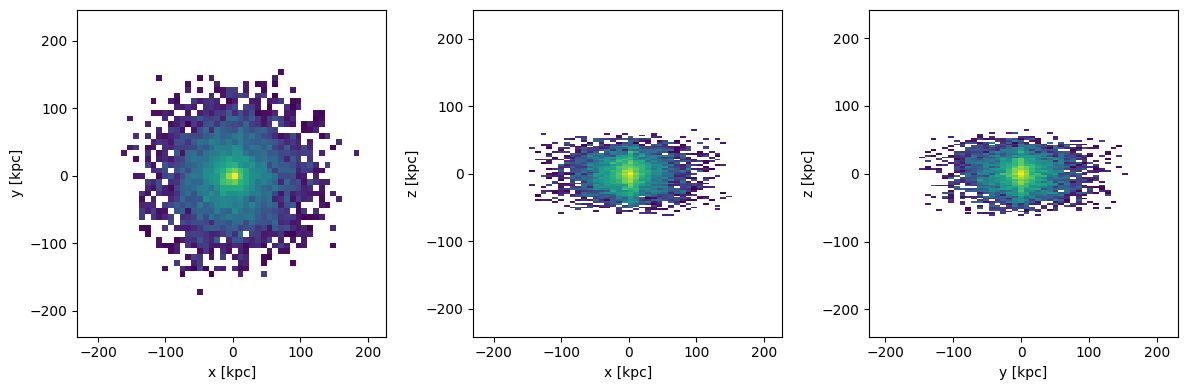

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

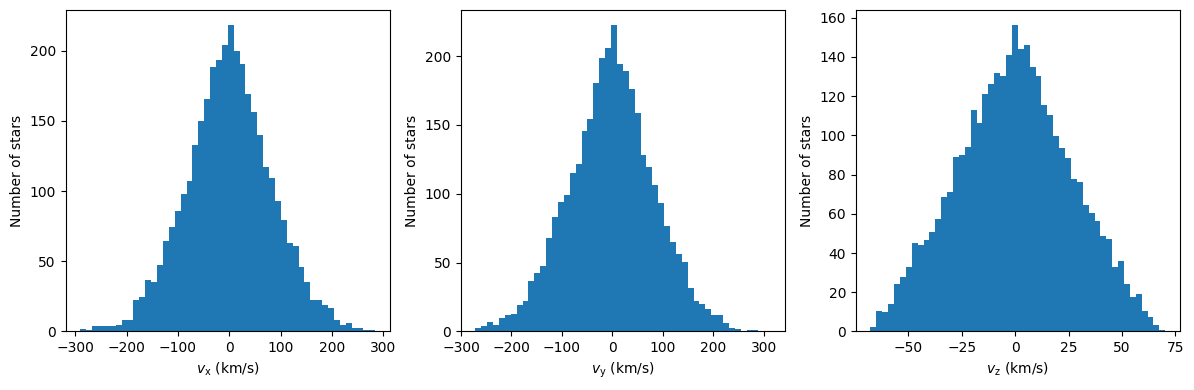

In [10]:
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

R = jnp.sqrt(x**2 + y**2)
mask = R > 0.0
v_x_masked = v_x[mask]
v_y_masked = v_y[mask]
v_z_masked = v_z[mask]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(v_x_masked, bins=50, weights=soft_weights[mask])#, range=(-500, 500))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")


plt.subplot(1,3,2)
plt.hist(v_y_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(1,3,3)
plt.hist(v_z_masked, bins=50, weights=soft_weights[mask])
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

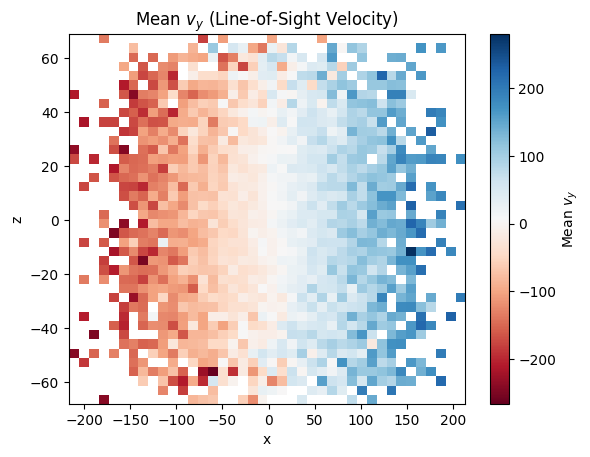

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.average(v_y[mask], weights=soft_weights[mask])

# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu') #, vmin=-10000, vmax=10000)#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()

In [12]:
import jax
import jax.numpy as jnp

def compute_density_jax(x, y, z, weights, r_bins, z_bins):
    # 1. Compute radial distance r
    r = jnp.sqrt(x**2 + y**2)

    # 2. Use histogram2d to accumulate weights efficiently
    # This replaces the entire fori_loop and digitize logic
    counts, _, _ = jnp.histogram2d(
        r, z, 
        bins=[r_bins, z_bins], 
        weights=weights
    )

    # 3. Compute the volume of each bin
    # Use midpoint r for volume calculation to be more accurate
    r_mid = (r_bins[:-1] + r_bins[1:]) / 2
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    
    # Calculate volume of cylindrical shell: V = 2 * pi * r * dr * dz
    bin_volumes = 2 * jnp.pi * jnp.outer(r_mid * r_widths, z_widths)

    # 4. Normalize
    density = counts / bin_volumes
    
    return density

In [13]:
density = compute_density_jax(x, y, z, soft_weights, r_bins=jnp.linspace(0, 2, 10), z_bins=jnp.linspace(-1, 1, 10))

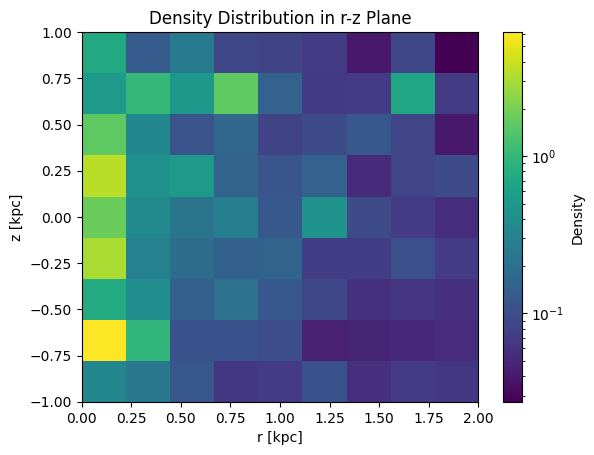

In [14]:
plt.imshow(density.T, origin='lower', aspect='auto',
           extent=[0, 2, -1, 1], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Density Distribution in r-z Plane')
plt.show()

In [15]:
import jax
import jax.numpy as jnp

def compute_laplacian_on_grid(potential, theta, r_bins, z_bins):
    """
    Computes nabla^2 Phi (Laplacian) on the centers of the R-Z bins.
    """
    
    # 1. Define the Laplacian for a SINGLE point (x, y, z)
    def potential_wrapper(x, y, z):
        return potential(x, y, z, *theta)

    def laplacian_fn(x, y, z):
        # jax.hessian returns a 3x3 matrix of second derivatives
        # argnums=(0, 1, 2) makes it return a nested tuple structure relative to x,y,z
        # However, it's easier to treat input as a vector for Hessian logic,
        # but since our function takes scalars, we can just sum unmixed 2nd derivatives.
        
        # Method A: Direct curvature calculation (faster/simpler than full Hessian)
        # We use simple nested grad or specific derivative operators
        d2dx2 = jax.grad(lambda x_: jax.grad(potential_wrapper, argnums=0)(x_, y, z))(x)
        d2dy2 = jax.grad(lambda y_: jax.grad(potential_wrapper, argnums=1)(x, y_, z))(y)
        d2dz2 = jax.grad(lambda z_: jax.grad(potential_wrapper, argnums=2)(x, y, z_))(z)
        
        return d2dx2 + d2dy2 + d2dz2

    # 2. Vectorize the Laplacian function
    # Maps over inputs x, y, z
    laplacian_vmap = jax.vmap(laplacian_fn, in_axes=(0, 0, 0))

    # 3. Setup Grid (Bin Centers)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    
    # Create Meshgrid (indexing='ij' matches density shape)
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # 4. Convert R-Z to Cartesian X-Y-Z
    # We evaluate at y=0, so x=R
    X_flat = R_grid.flatten()
    Y_flat = jnp.zeros_like(X_flat)
    Z_flat = Z_grid.flatten()

    # 5. Compute
    laplacian_flat = laplacian_vmap(X_flat, Y_flat, Z_flat)
    
    # Reshape back to (N_r, N_z)
    laplacian_grid = laplacian_flat.reshape(R_grid.shape)
    
    return laplacian_grid
